<a href="https://colab.research.google.com/github/NGeorggin/COMPSCI175FinalProject/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#COMPSCI 175 Final Project. Project Group 7.

##Libraries and Imports

In [1]:
# Below are all RLCard's Import Statements and Associated Libraries that we need for our models according to (Getting Started, n. d.)
# Imported common libraries that we will use for various operations for RLCard, DQN, NN, etc.
!pip install rlcard
import rlcard
from rlcard.envs import Env
from rlcard.agents import RandomAgent, DQNAgent
from rlcard.games.base import Card
from rlcard.games.nolimitholdem import (
    Game,
    Round,
    Action
)
from rlcard.utils import ( # (rlcard.utils, n. d.)
    get_device,
    set_seed,
    tournament,
    reorganize,
    Logger,
    plot_curve,
)
import os
import argparse
from enum import Enum
from collections import OrderedDict
import csv
import numpy as np
from copy import deepcopy

# Import statements for Neural Networks from (Georggin, 2024).
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.0/269.0 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rlcard: filename=rlcard-1.2.0-py3-none-any.whl size=325794 sha256=7b844b91284a5340a95dbae2f99ea2f76752c6cf0eabbe7f141cd4cfd0d682e3
  Stored in directory: /root/.cache/pip/wheels/a5/0a/39/26d73b035027276e526bec94b0217ed799109d7890c34a7d9b
Successfully built rlcard


##Neural Network Construction (For Guessing Opponent's Hand)

In [2]:
class NNPolicy(nn.Module): # Making a class for NN (Georggin, 2024)
    def __init__(self, hidden):
        super(NNPolicy, self).__init__() # Super Init from NN imported module (Georggin, 2024)

        """
        Input: Community Cards (5 input nodes), Opponent's Money they've Bet (1 input node), Opponent's Last Move (1 input node). 7 input nodes in total.
        Output: Array of 10 probabilities that the opponent has a particular hand.
        10 possible hands are: high card, pair, two pair, three of a kind, straight, flush, full house, four of a kind, straight flush, royal flush.
        """

        # Establish the convolutional layers to handle the proper size of input and outputs in a way similar to (Georggin, 2024)
        self.fc1 = nn.Conv1d(1, hidden, 1)
        self.fc2 = nn.Conv1d(hidden, hidden, 1)
        self.fc3 = nn.Conv1d(hidden, 10, 7)


    def probOpponentHand(self, communityCards, oppMoney, oppLastMove, device): # Getting a projection from the NN (Georggin, 2024)

        while len(communityCards) < 5:
          communityCards.append(-1) # Denotes a card slot that has not been revealed yet

        # Add all input points into a single array
        x = communityCards[:]
        x.append(oppMoney)
        x.append(oppLastMove)


        x = torch.tensor(x).float().unsqueeze(0) # Tensor-ify the input array (Georggin, 2024).

        # Applying NN layers (Georggin, 2024)
        x = self.fc1(x) # Applies Convolutional Layer 1 to the values.
        x = F.relu(x)   # Applies Some Standardizing to the values (Just using ReLU because that is what we used in the HW2).
        x = self.fc2(x) # Applies Convolutional Layer 2 to the values.
        x = F.relu(x)   # Applies Some Standardizing to the values (Just using ReLU because that is what we used in the HW2).
        x = self.fc3(x) # Applies Convolutional Layer 3 to the values.

        # Changing the layers from an array of 10 x 1-element tensors to 1 x 10-element tensor for processing when we get the action.
        final = []
        for e in x:
          final.append(e)

        final = torch.tensor(final).float().unsqueeze(0).to(device) # Format the array into tensors (Georggin, 2024)

        return F.softmax(final, dim=1) # Applies Some Standardizing to the values (Just using Softmax because that is what we used in the HW2).

    def getAction(self, communityCards, oppMoney, oppLastMove, device): # (Georggin, 2024)
        probs = self.probOpponentHand(communityCards, oppMoney, oppLastMove, device).cpu() # Get the opponent hand projection from the NN (Georggin, 2024)
        m = Categorical(probs) # Categorical (Georggin, 2024)
        action = m.sample() # Choose an action based on the probabilities produced (Georggin, 2024)
        return action.item(), m.log_prob(action) # (Georggin, 2024) # Chosen action is categorized is some integer E [0, 9]


##Reinforcement Algorithm for the Neural Network

In [3]:
def cardSTOI(listCards):

    # Creating a card2index dictionary that aligns cards to integer representation (State Representation of No-Limit Texas Hold'em, n. d.)
    # We ran into errors when importing this dictionary from RLCard, so we just manually make it here instead.
    card2index = dict()
    num = 0
    for s in ['S', 'H', 'D', 'C']:
      for r in ['A','2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q','K']:
        card2index[s+r] = num
        num += 1

    # Converts each of the cards in the hand into integer values according to the dictionary so that the NN can interpret the cards.
    newList = []
    for c in listCards:
      newList.append(card2index[c])
    return newList

def evaluateHandType(communityCards, twoCards):
    """
    The Hands are labeled ...
      0. High Card
      1. Pair
      2. Two Pair
      3. Three Of A Kind
      4. Straight
      5. Flush
      6. Full House
      7. Four Of A Kind
      8. Straight Flush
      9. Royal Flush
    Because these hands are how the NN has been arranged to distribute probabilities.
    The NN returns a tensor of 10 elements, one for each of the above hands.
    """

    bigCardList = communityCards[:] + twoCards[:] # Compile all cards into a list.

    if len(bigCardList) < 5: # If there are fewer than 5 cards in our list, then it is impossible to make a hand. Just return.
        return -1

    # Place the frequency of certain cards appearing in dictionaries for easy access later
    suits = {'S':0 , 'C':0 , 'H':0 , 'D':0}
    ranks = {'2':0, '3':0, '4':0, '5':0, '6':0, '7':0, '8':0, '9':0, 'T':0, 'J':0, 'Q':0,'K':0,'A':0}

    for c in bigCardList:
        suits[c[0]] += 1
        ranks[c[1]] += 1

    # For finding successive cards, we can place instances in a bitstring-like structure and check for instances below
    stringOfRanks = ""
    for v in list(ranks.values()):
        if v == 0:
          stringOfRanks += "0"
        else:
          stringOfRanks += "1"


    if "11111" in stringOfRanks and (5 in list(suits.values()) or 6 in list(suits.values()) or 7 in list(suits.values())) and stringOfRanks.endswith("11111"): ## Royal Flush Conditions
        return 9
    elif "11111" in stringOfRanks and (5 in list(suits.values()) or 6 in list(suits.values()) or 7 in list(suits.values())): ## Straight Flush
        return 8
    elif 4 in list(ranks.values()): ## Four of a Kind
        return 7
    elif (3 in list(ranks.values()) and 2 in list(ranks.values())) or list(ranks.values()).count(3) >= 2: ## Full House
        return 6
    elif 5 in list(suits.values()) or 6 in list(suits.values()) or 7 in list(suits.values()): ## Flush
        return 5
    elif "11111" in stringOfRanks: ## Straight
        return 4
    elif 3 in list(ranks.values()): ## Three Of A Kind
        return 3
    elif list(ranks.values()).count(2) >= 2: ## Two Pair
        return 2
    elif 2 in list(ranks.values()): ## Pair
        return 1
    else: ## High Card (if nothing else happens)
        return 0

## Combining Implementation of both models

In [4]:
def NNAffectPayoff(policy, optimizer, trajectories, payoffs, device):

    # Getting relevant information from the trajectories data structure.
    agentHand = trajectories[0][-1]['raw_obs']['hand']
    communityCards = trajectories[0][-1]['raw_obs']['public_cards']
    __, oppMoney = trajectories[0][-1]['raw_obs']['all_chips']
    oppHandActual = trajectories[-1][-1]['raw_obs']['hand']
    actionRecord = trajectories[-1][-1]['action_record']

    oppLastMove = -1
    for move in actionRecord[::-1]: # Cycle from the most recent move to the least recent
      if move[0] == 1: # See which move was last made by the opponent

        # Actions in [0, 4] according to action encoding (Action Encoding of No-Limit Texas Hold'em, n. d.)
        # Add the number that is associated in enumeration as the opponent's last move.
        if move[1] == Action(0):
          oppLastMove = 0
        elif move[1] == Action(1):
          oppLastMove = 1
        elif move[1] == Action(2):
          oppLastMove = 2
        elif move[1] == Action(3):
          oppLastMove = 3
        elif move[1] == Action(4):
          oppLastMove = 4
        break


    # Compute an amount that the payoffs will be adjusted by
    DQNExistingReward = abs(payoffs[0])
    rewardAdjustment = 0.1 * DQNExistingReward

    oppHandType, oppLogProb = policy.getAction(cardSTOI(communityCards), oppMoney, oppLastMove, device) # Get the projected hand the opponent has using the NN

    agentHandType = evaluateHandType(communityCards, agentHand) # Get the agent hand's value

    # Skips if there is a projected tie or if there is an edge case
    if agentHandType == oppHandType or oppHandType == -1 or agentHandType == -1:
        return payoffs

    # Improve the agent's rewards if they have a perceived better hand
    elif agentHandType > oppHandType:
        payoffs[0] += rewardAdjustment
        payoffs[1] -= rewardAdjustment

    # Decrease the agent's rewards if they have a perceived worse hand
    elif agentHandType < oppHandType:
        payoffs[0] -= rewardAdjustment
        payoffs[1] += rewardAdjustment

    nnReturnProbs = policy.probOpponentHand(cardSTOI(communityCards), oppMoney, oppLastMove, device) # Get the probabilities of the opponent having a certain hand from the NN.

    # Create an expected rewards array that will be added to the policy array in the same manner as (Georggin, 2024)
    # This is done by adding zero to each of the 10 hands except we add a factor of the reward adjustment for the most likely opponent hand
    rewardArray = [0] * len(list(nnReturnProbs)[0])
    rewardArray[oppHandType] = 2 * rewardAdjustment

    # Compute a policy loss array in a manner similar to (Georggin, 2024) to allow optimizer to improve the NN.
    policyLoss = []
    for i in range(len(nnReturnProbs)): # (Georggin, 2024)
        policyLoss.append(1 * (1-nnReturnProbs[0][i]) * rewardArray[i]) # (Georggin, 2024)
    policyLoss = torch.tensor(policyLoss, requires_grad=True).sum() # We had trouble with establishing a gradient descent, but adding a `requires_grad` parameter as indicated by (Wen, et al., 2017) on the Pytorch Docs solved our problem

    # Update the NN using the optimizer (Georggin, 2024).
    optimizer.zero_grad()
    policyLoss.backward()
    optimizer.step()

    return payoffs

##DQN

In [15]:
def DQNtrain(args): # (Getting Started, n. d.; rlcard.games.nolimitholdem, n. d.)

    # Check whether gpu is available (rlcard.utils, n. d.)
    device = get_device()

    # Setting the seed that we declare in the arguments (Getting Started, n. d.; rlcard.utils, n. d.)
    set_seed(args.seed)

    # Make the environment with seed (Getting Started, n. d.; rlcard.games.nolimitholdem, n. d.)
    env = rlcard.make(
        args.env,
        config={
            'seed': args.seed,
        }
    )

    # Make a DQN Agent (Getting Started, n. d.; rlcard.agents.dqn_agent, n. d.)
    agent = DQNAgent(
        num_actions=env.num_actions,
        state_shape=env.state_shape[0],
        mlp_layers=[64,128],
        device=device,
        batch_size=64
    )

    # (Getting Started, n. d.; No-limit Texas Hold'em, n. d.; rlcard.games.nolimitholdem, n. d.)
    games_won = 0
    csv_path2 = os.path.join(args.log_dir, 'result.csv') # Put the model results in a .csv file to analyze
    with open(csv_path2, 'w') as f:
        csv_writer = csv.writer(f)
        csv_writer.writerow(['episode', 'reward'])

    # Make the two players be the following: Our Agent, Random Opponent. (Getting Started, n. d.; rlcard.games.nolimitholdem, n. d.)
    agents = [agent]
    for _ in range(1, env.num_players):
        agents.append(DQNAgent(
          num_actions=env.num_actions,
          state_shape=env.state_shape[0],
          mlp_layers=[64,128],
          device=device,
          batch_size=64
        ))
    env.set_agents(agents)

    agent = torch.load(args.save_path)
    agents[1] = torch.load(args.save_path)

    nn = NNPolicy(256) # Create the Neural Network (with an arbitrary yet sufficiently large hidden layer size value).
    optimizer = optim.Adam(nn.parameters(), lr=0.001) # Create an Optimizer for updating the NN.

    nn = torch.load(os.path.join('experiments/no_limit_holdem_dqn_result/', 'nnmodel.pth'))

    with Logger(args.log_dir) as logger: # Log the training, results, and all associated information using a Logger (Getting Started, n. d.; rlcard.utils, n. d.)
        for episode in range(args.num_episodes):

            # Get environment data from a run (Getting Started, n. d.; rlcard.envs.nolimitholdem, n. d.)
            trajectories, payoffs = env.run(is_training=True)

            if payoffs[0] > 0: # (Getting Started, n. d.)
                games_won += 1

            payoffs = NNAffectPayoff(nn, optimizer, trajectories, payoffs, device) # Update the payoffs according to what the NN projects.

            # "Reorganaize the data to be state, action, reward, next_state, done" (Getting Started, n. d.; No-limit Texas Hold'em, n. d.)
            trajectories = reorganize(trajectories, payoffs) # (Getting Started, n. d.; rlcard.utils, n. d.; No-limit Texas Hold'em, n. d.)

            # (Getting Started, n. d.)
            # "Feed transitions into agent memory, and train the agent
            # "Here, we assume that DQN always plays the first position
            # "and the other players play randomly (if any)"" (Getting Started, n. d.).
            for ts in trajectories[0]:
                agent.feed(ts)

            # Evaluate the performance. Play with random agents. Log everything in the save files (Getting Started, n. d.; rlcard.games.nolimitholdem, n. d.)
            if episode % args.evaluate_every == 0: # (Getting Started, n. d.; rlcard.utils, n. d.)
                logger.log_performance(
                    episode,
                    tournament(
                        env,
                        args.num_eval_games,
                    )[0]
                )
                with open(csv_path2, 'a') as f: # (Getting Started, n. d.)
                    csv_writer = csv.writer(f)
                    if episode == 0:
                        win_rate = 0
                    else:
                        win_rate = games_won / episode
                    csv_writer.writerow([episode, win_rate])

        # Get the paths and plot the curve on a graphic to be returned at the end (Getting Started, n. d.; rlcard.utils, n. d.; rlcard.games.nolimitholdem, n. d.)
        csv_path, fig_path = logger.csv_path, logger.fig_path
        fig_path2 = os.path.join(args.log_dir, 'fig2.png')
        plot_curve(csv_path2, fig_path2, 'win_rate')

    # Plot the learning curve to print out at the end (Getting Started, n. d.; rlcard.utils, n. d.)
    plot_curve(csv_path, fig_path, args.algorithm)

--> Running on the CPU


<ipython-input-15-57661f94a909>:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent = torch.load(args.save_path)
<ipython-input-15-57661f94a909>:46: FutureWarning: You a

INFO - Step 113095, rl-loss: 1910.953369140625
----------------------------------------
  episode      |  0
  reward       |  -41.15
----------------------------------------
INFO - Step 113100, rl-loss: 950.9140014648438
INFO - Copied model parameters to target network.
INFO - Step 113296, rl-loss: 558.0076904296875
----------------------------------------
  episode      |  100
  reward       |  -42.278
----------------------------------------
INFO - Step 113472, rl-loss: 1217.0927734375
----------------------------------------
  episode      |  200
  reward       |  -41.7945
----------------------------------------
INFO - Step 113668, rl-loss: 1022.8825073242188
----------------------------------------
  episode      |  300
  reward       |  -41.3955
----------------------------------------
INFO - Step 113844, rl-loss: 1396.79052734375
----------------------------------------
  episode      |  400
  reward       |  -42.4095
----------------------------------------
INFO - Step 114024, 

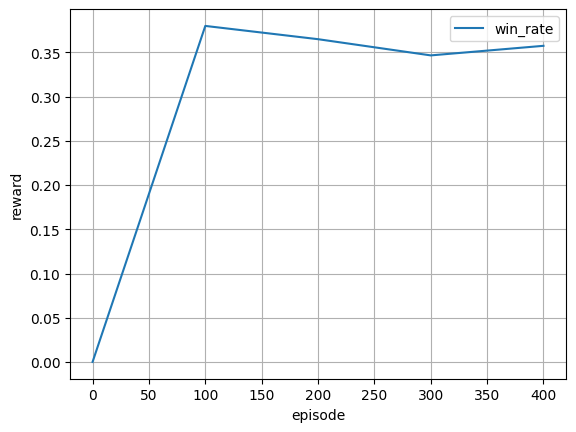

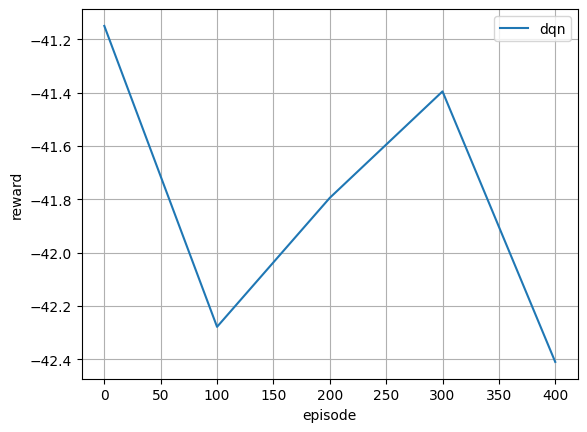

In [16]:
if __name__ == '__main__': # (Getting Started, n. d.)
    parser = argparse.ArgumentParser("DQN example in RLCard") # (Getting Started, n. d.)

    # Each of these parser argeuments are done while keeping with the format specified in (Getting Started, n. d.).

    parser.add_argument( # Make the game model we are working off the 'no-limit-holdem' game from RLCard (Getting Started, n. d.)
        '--env',
        type=str,
        default='no-limit-holdem',
        choices=[
            'no-limit-holdem',
        ],
    )
    parser.add_argument( # Make the primary RL model that our game will be the DQN (Getting Started, n. d.; rlcard.agents.dqn_agent, n. d.)
        '--algorithm',
        type=str,
        default='dqn',
        choices=[
            'dqn',
        ],
    )
    parser.add_argument( # Cuda Argument (Getting Started, n. d.)
        '--cuda',
        type=str,
        default='',
    )
    parser.add_argument( # Constant seed for deterministic choices when replicating the model (Getting Started, n. d.)
        '--seed',
        type=int,
        default=42,
    )
    parser.add_argument( # Constant number of episodes to run (Getting Started, n. d.)
        '--num_episodes',
        type=int,
        default=500,
    )
    parser.add_argument( # Constant number of games to evaluate (Getting Started, n. d.)
        '--num_eval_games',
        type=int,
        default=2000,
    )
    parser.add_argument( # Constant number of every so many games is when we will run an evaluation to see how well we are doing (Getting Started, n. d.)
        '--evaluate_every',
        type=int,
        default=100,
    )
    parser.add_argument( # Establish a dictionary in which to store the files (Getting Started, n. d.)
        '--log_dir',
        type=str,
        default='experiments/no_limit_holdem_dqn_result/',
    )
    parser.add_argument( # Path to save the DQN model as part of this program (Getting Started, n. d.)
        '--save_path',
        type=str,
        default=os.path.join('experiments/no_limit_holdem_dqn_result/', 'model.pth'),
    )

    args, unknown = parser.parse_known_args() # (Getting Started, n. d.)

    os.environ["CUDA_VISIBLE_DEVICES"] = args.cuda # (Getting Started, n. d.)

    DQNtrain(args) # Run the training with the arguments mentioned above. (Getting Started, n. d.)

##References

Action Encoding of No-Limit Texas Hold'em. (n. d.). RLCard Data Lab. https://rlcard.org/games.html#action-encoding-of-no-limit-texas-hold-em
Georggin, N. E. (2024, November 10). Homework 2. COMPSCI 175 LEC A Gradescope. https://canvas.eee.uci.edu/courses/68219/assignments/1470589
    Note: This above assignment was completed with material provided by the class at Xie, X. (2024). HW2.ipynb. Google Drive. https://drive.google.com/file/d/1rJq6sne8xmhV3UEK_V13w_hhVQzMDRqO/view
Getting Started. (n. d.). RLCard Data Lab. https://rlcard.org/getting_started.html
No-limit Texas Hold'em. (n. d.). RLCard Data Lab. https://rlcard.org/games.html#no-limit-texas-hold-em
rlcard.agents.dqn_agent. (n. d.). RLCard Data Lab. https://rlcard.org/rlcard.agents.html#module-rlcard.agents.dqn_agent
rlcard.envs.nolimitholdem. (n. d.). RLCard Data Lab. https://rlcard.org/rlcard.envs.html#module-rlcard.envs.nolimitholdem
rlcard.games.nolimitholdem. (n. d.). RLCard Data Lab. https://rlcard.org/rlcard.games.nolimitholdem.html
rlcard.utils. (n. d.). RLCard Data Lab. https://rlcard.org/rlcard.utils.html
State Representation of No-Limit Texas Hold'em. (n. d.). RLCard Data Lab. https://rlcard.org/games.html#state-representation-of-no-limit-texas-hold-em
Wen, Z., et al. (2017, December). RuntimeError: element 0 of variables does not require grad and does not have a grad_fn. PyTorch. https://discuss.pytorch.org/t/runtimeerror-element-0-of-variables-does-not-require-grad-and-does-not-have-a-grad-fn/11074